In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

from utils import get_observed_node_sets

import meshcat
import meshcat.geometry as meshcat_geom

Generating from folder  sink/plates_cups_and_bowls/plates
sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado'>
sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise'>
Generating from folder  sink/plates_cups_and_bowls/cups
sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue :  <class '

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/
Meshcat url:  http://127.0.0.1:7006/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [3]:
# Load in datasets.
observed_node_sets, observed_node_sets_outliers = get_observed_node_sets(reconvert=True)

In [6]:
total_of_each_type = {"DishBin": 0}
for model_type_set in [PlateModels, CupModels, BowlModels]:
    for model_type in model_type_set:
        total_of_each_type[model_type.__name__] = 0
for observed_nodes in observed_node_sets:
    for node in observed_nodes:
        total_of_each_type[type(node).__name__] += 1
print(total_of_each_type)


{'DishBin': 30, 'sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring': 12, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado': 12, 'sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise': 21, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise': 0, 'sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue': 12, 'sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow': 12, 'sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White': 14, 'sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl': 9, 'sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue': 10, 'sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose': 8}


In [7]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)
pyro.set_rng_seed(42)
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
supertree = grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))

sampled_tree = grammar.sample_tree(detach=True)
observed_nodes = sampled_tree.get_observed_nodes()

vis["initial_sample"].delete()
draw_scene_tree_contents_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="initial_sample/contents")
draw_scene_tree_structure_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="initial_sample/structure", node_sphere_size=0.01)

[2022-01-11 15:58:42.165] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Supertree size  613


In [8]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object. Use no pose proposals, as this grammar is pure-dependency.
trees = infer_mle_tree_with_mip_from_proposals(
    grammar, observed_nodes, {}, verbose=1, N_solutions=5, max_recursion_depth=10
)
vis["sampled_scene_parse"].delete()
draw_scene_tree_contents_meshcat(trees[0], zmq_url=vis.window.zmq_url, prefix="sampled_scene_parse/contents")
for k, tree in enumerate(trees[:3]):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_scene_parse/structure/%d" % k, node_sphere_size=0.01)

Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Tue Jan 11 15:58:42 2022

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 2111 rows, 741 columns and 4901 nonzeros
Model fingerprint: 0xa7dafd1f
Variable types: 0 continuous, 741 integer (741 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [5e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+00]
Presolve removed 2111 rows and 741 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 4.06044 

Optimal solution found (tolerance 1.00e-03)
Best objective 4.060443570577e+00, best bound 4.060443570577e+00, gap 0.0000%

Building tree for sol 0...


In [9]:
# Check we recover the GT parse tree for that  random scene.
print("Best parse score: ", trees[0].score(include_continuous=True))
print("GT tree score: ", sampled_tree.score(include_continuous=True))
deviations = []
for node in trees[0]:
    R = node.rotation.detach().numpy()
    deviations.append(np.sum(R.T.dot(R) - np.eye(3)))
print("Max deviation: ", np.max(np.abs(deviations)))

Best parse score:  tensor([-4.0604])
GT tree score:  tensor([-4.0604])
Max deviation:  1.0386656812411132e-15


# Approximate EM parameter fitting with IP parser

In [14]:
em = EMWrapper(grammar, observed_node_sets, parsing_strategy="ip_noproposals", do_nlp_refinement=False)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=10, num_workers=10, max_recursion_depth=10)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl): None
    (ObjectsInBowl): ConstrainedParameter()
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise): None
    (TerminalObject): ConstrainedParameter()
    (Plate): None
    (sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring): None
    (sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise): None
    (TerminalCup): ConstrainedParameter()
    (ObjectsOnPlate): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White): None
    (TerminalBowl): ConstrainedParameter()
    (DishBin): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow): None
    (sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose):

In [25]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar.torch")
with open("fit_em.pickle", "wb") as fp:
    pickle.dump(em, fp)

# Plotting and inspection of EM fitting process

In [29]:
with open("fit_em.pickle", "rb") as fp:
    em = pickle.load(fp)
assert len(em.grammar_iters) > 0

Text(0.5, 1.0, 'Fitting progress curve')

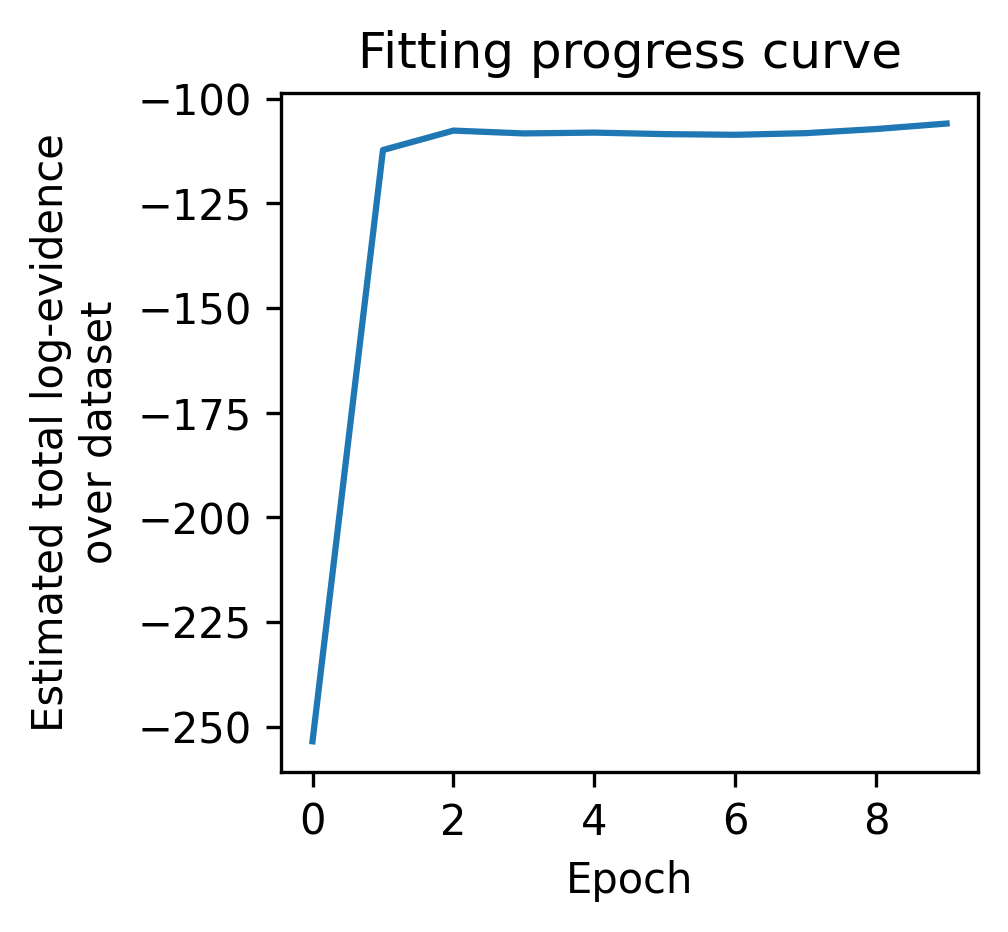

In [33]:
plt.figure(dpi=300).set_size_inches(3, 3)
plt.plot([sum(x) for x in em.log_evidence_iters])
plt.xlabel("Epoch")
plt.ylabel("Estimated total log-evidence\nover dataset")
plt.title("Fitting progress curve")

DishBin : 
Final params:  tensor([2.2251e-308,  1.7591e-01,  2.1818e-01,  5.2686e-01,  7.9050e-02,
         7.7088e-23, 2.2251e-308])
mean tensor([[ 0.0000,  0.0000,  0.1000],
        [ 0.0012,  0.0439,  0.0558],
        [ 0.0006,  0.0475,  0.0542],
        [-0.0009,  0.0482,  0.0544],
        [-0.0025,  0.0494,  0.0554],
        [-0.0032,  0.0497,  0.0559],
        [-0.0036,  0.0498,  0.0563],
        [-0.0041,  0.0501,  0.0567],
        [-0.0047,  0.0504,  0.0573],
        [-0.0056,  0.0501,  0.0581],
        [-0.0065,  0.0495,  0.0592]])
0:xyz:mean final: tensor([-0.0065,  0.0495,  0.0592])
variance tensor([[0.0100, 0.0200, 0.0050],
        [0.0073, 0.0281, 0.0023],
        [0.0073, 0.0278, 0.0022],
        [0.0074, 0.0275, 0.0022],
        [0.0075, 0.0274, 0.0023],
        [0.0075, 0.0274, 0.0023],
        [0.0075, 0.0275, 0.0024],
        [0.0075, 0.0275, 0.0024],
        [0.0076, 0.0276, 0.0024],
        [0.0076, 0.0276, 0.0024],
        [0.0076, 0.0277, 0.0024]])
0:xyz:variance 

Object : 
Final params:  tensor([0.3471, 0.2225, 0.4304])


Bowl : 


TerminalBowl : 
Final params:  tensor([0.3333, 0.3704, 0.2963])
ObjectsInBowl : 
Final params:  tensor([4.2521e-01, 5.1155e-01, 6.3237e-02, 3.4720e-65])
mean tensor([[ 0.0000,  0.0000,  0.0500],
        [ 0.0039, -0.0030,  0.0492],
        [ 0.0090, -0.0026,  0.0549],
        [ 0.0120, -0.0012,  0.0545],
        [ 0.0115,  0.0022,  0.0516],
        [ 0.0114,  0.0037,  0.0505],
        [ 0.0115,  0.0044,  0.0504],
        [ 0.0116,  0.0053,  0.0506],
        [ 0.0111,  0.0062,  0.0502],
        [ 0.0099,  0.0057,  0.0489],
        [ 0.0087,  0.0049,  0.0489]])
0:xyz:mean final: tensor([0.0087, 0.0049, 0.0489])
variance tensor([[0.0050, 0.0050, 0.0050],
        [0.0012, 0.0023, 0.0028],
        [0.0008, 0.0017, 0.0022],
        [0.0006, 0.0016, 0.0018],
        [0.0005, 0.0014, 0.0015],
        [0.0004, 0.0013, 0.0014],
        [0.0004, 0.0011, 0.0014],
        [0.0003, 0.0010, 0.0015],
        [0.0003, 0.0007, 0.0016],
        [0.0002, 0.0005, 0.0018],
        [0.0001, 0.0005, 0.0018]])

TerminalObject : 
Final params:  tensor([0.5435, 0.2951, 0.1614])


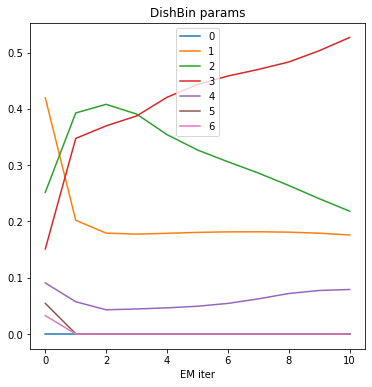

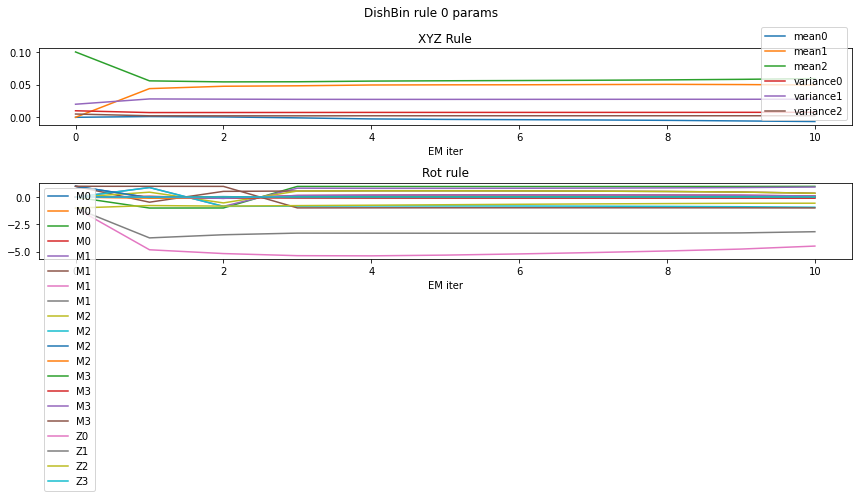

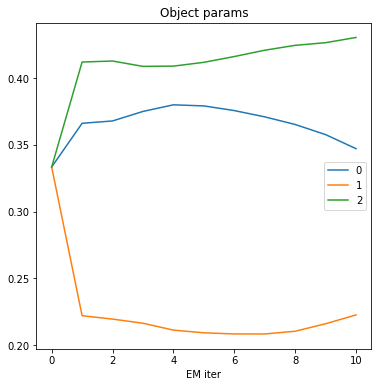

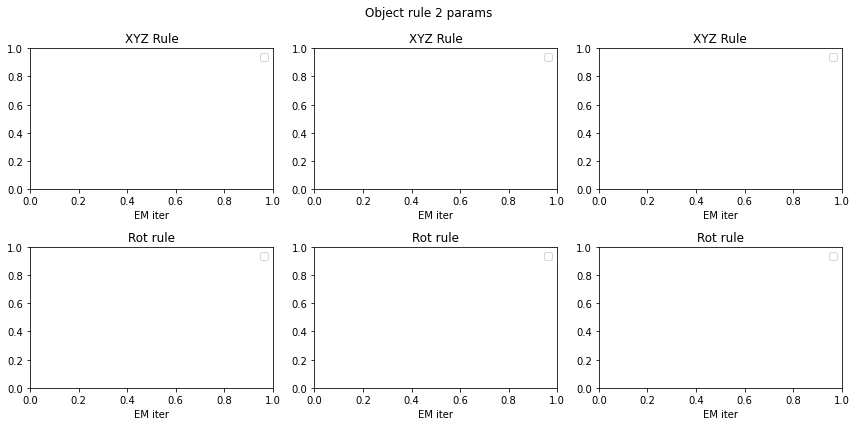

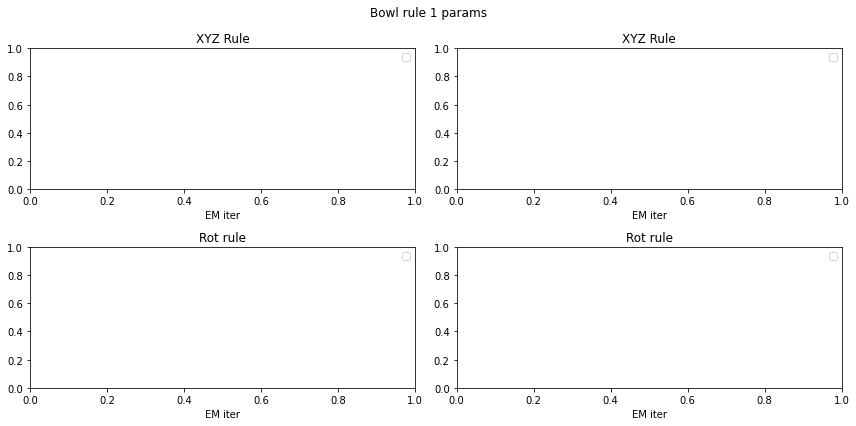

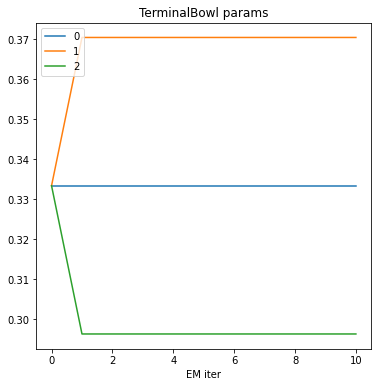

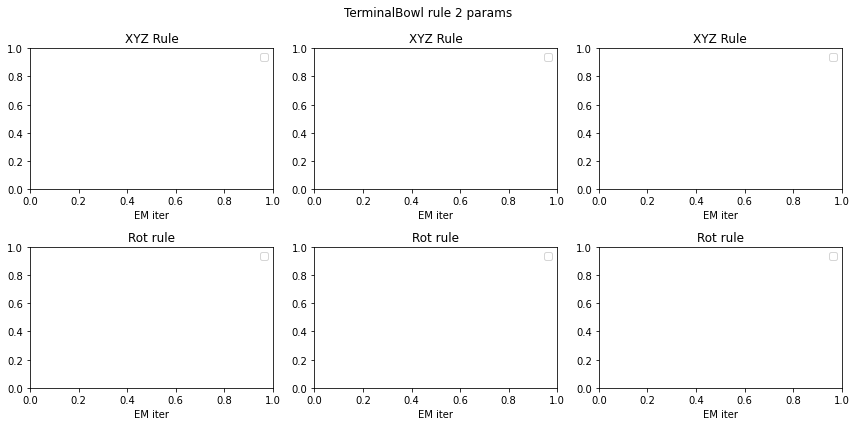

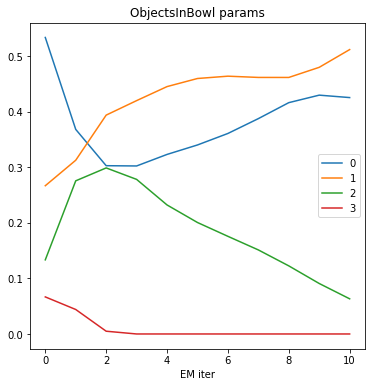

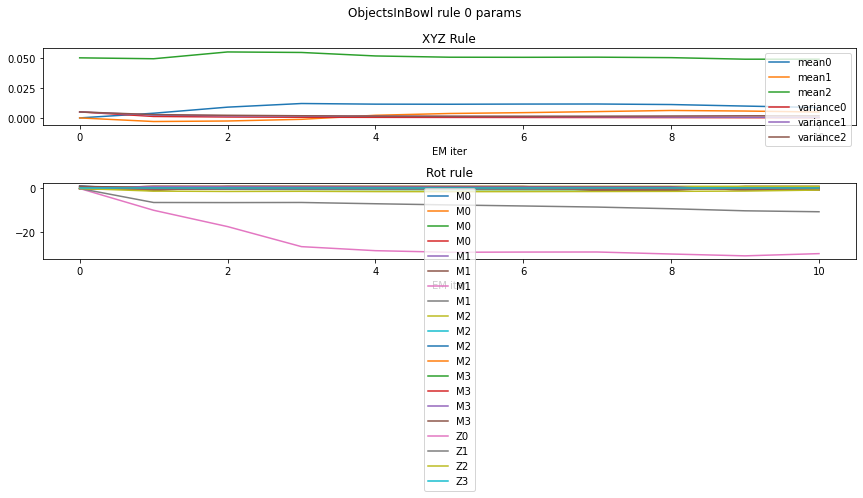

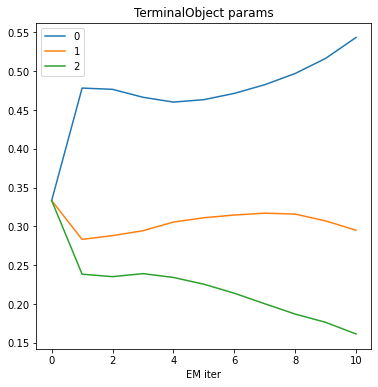

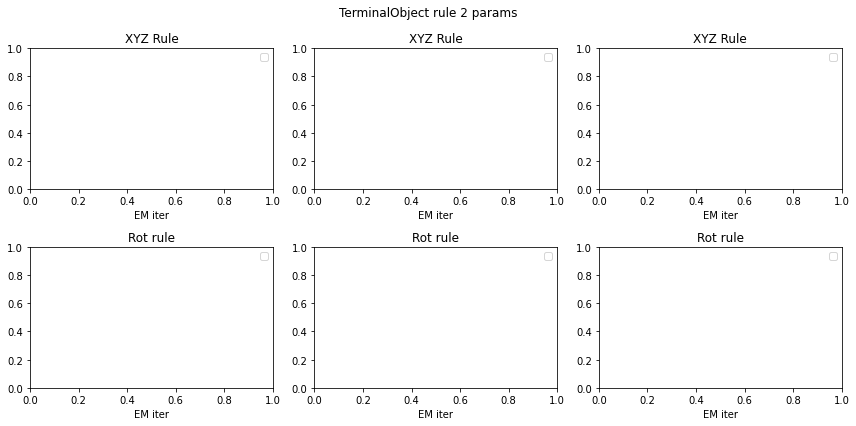

In [28]:
for node_type_to_plot in [DishBin, Object, Bowl, TerminalBowl, ObjectsInBowl, TerminalObject]:
    print(node_type_to_plot.__name__, ": ")
    em.plot_grammar_parameter_history(node_type_to_plot)

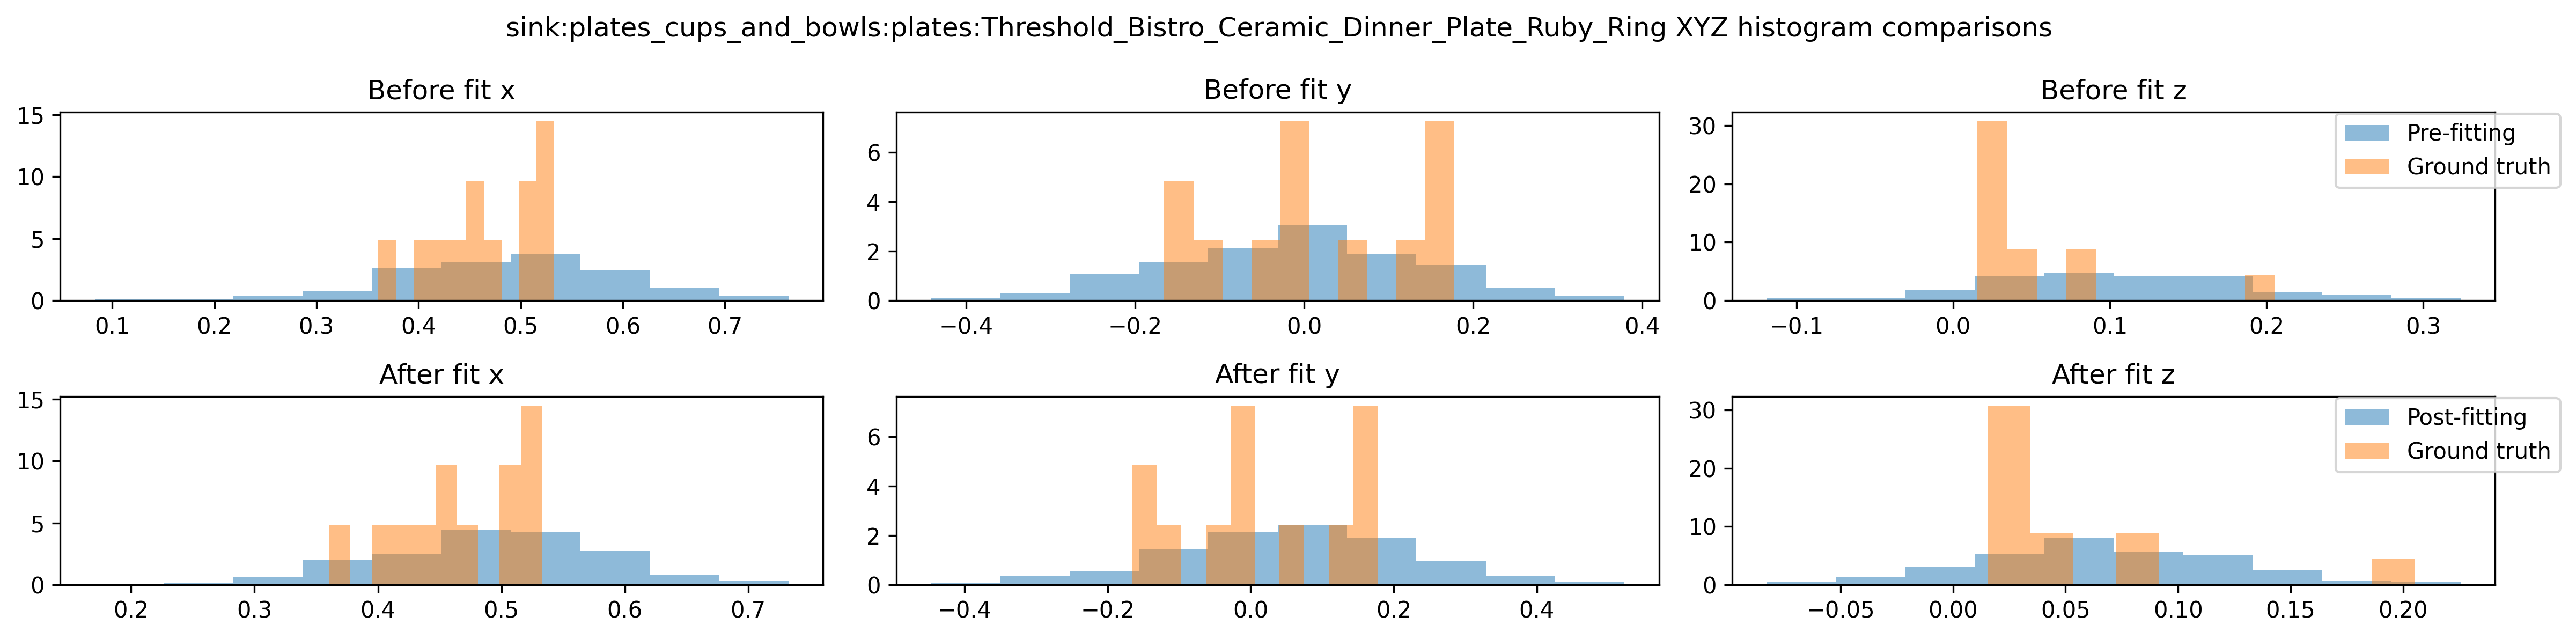

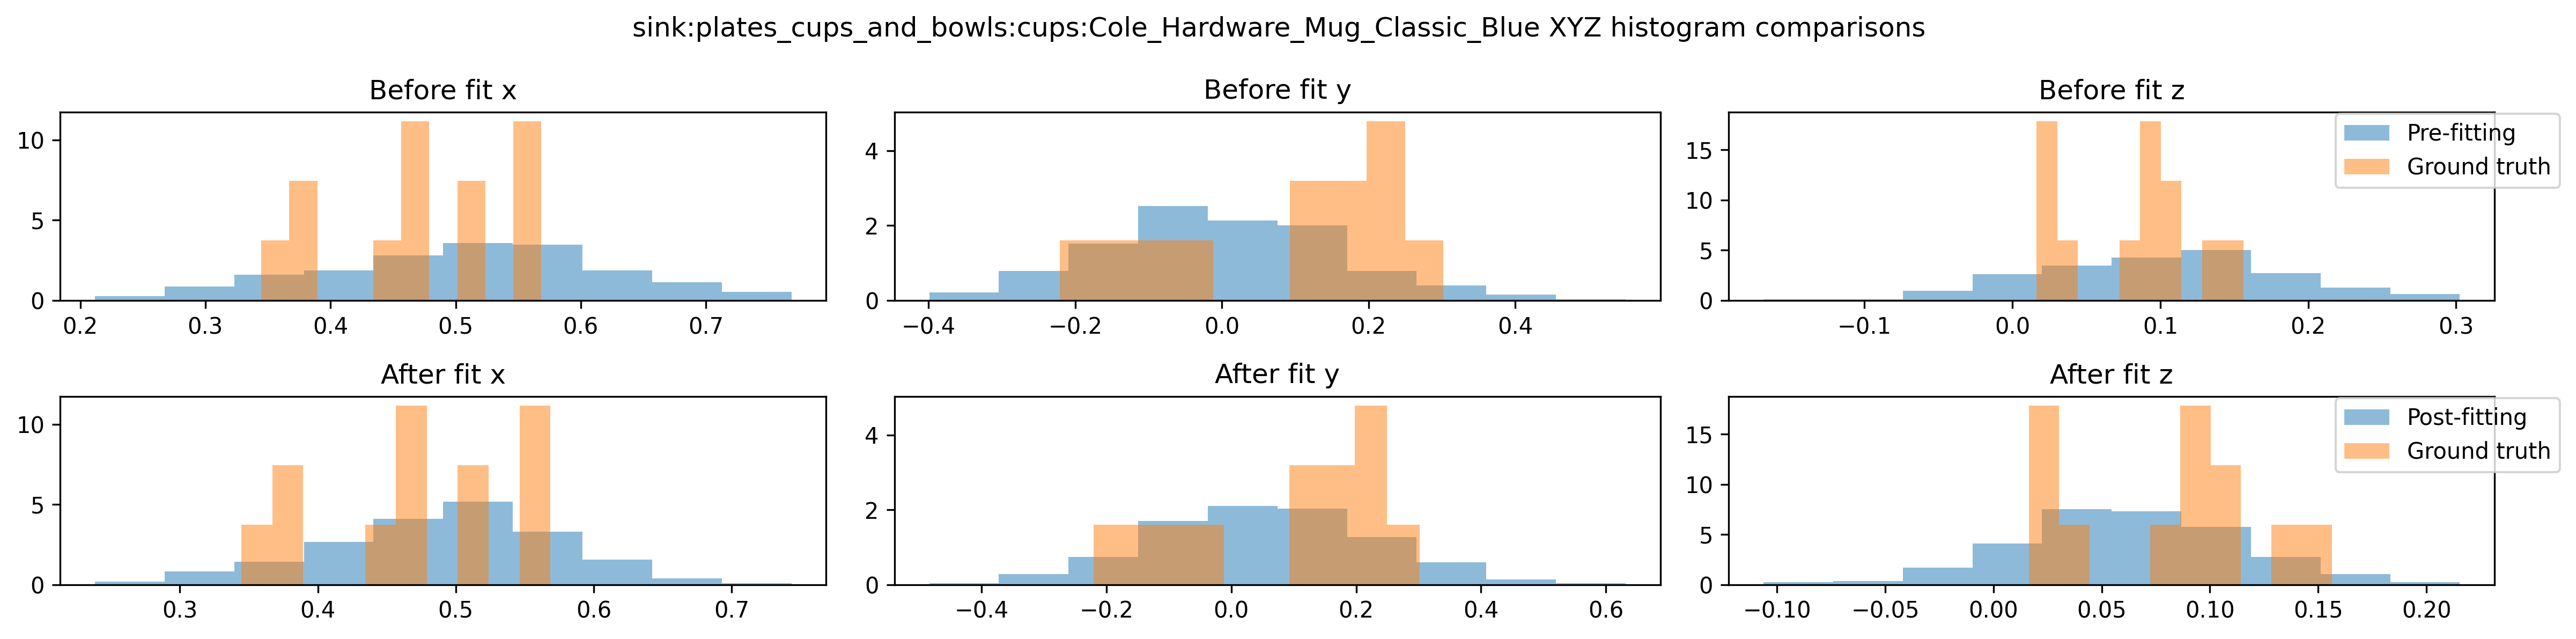

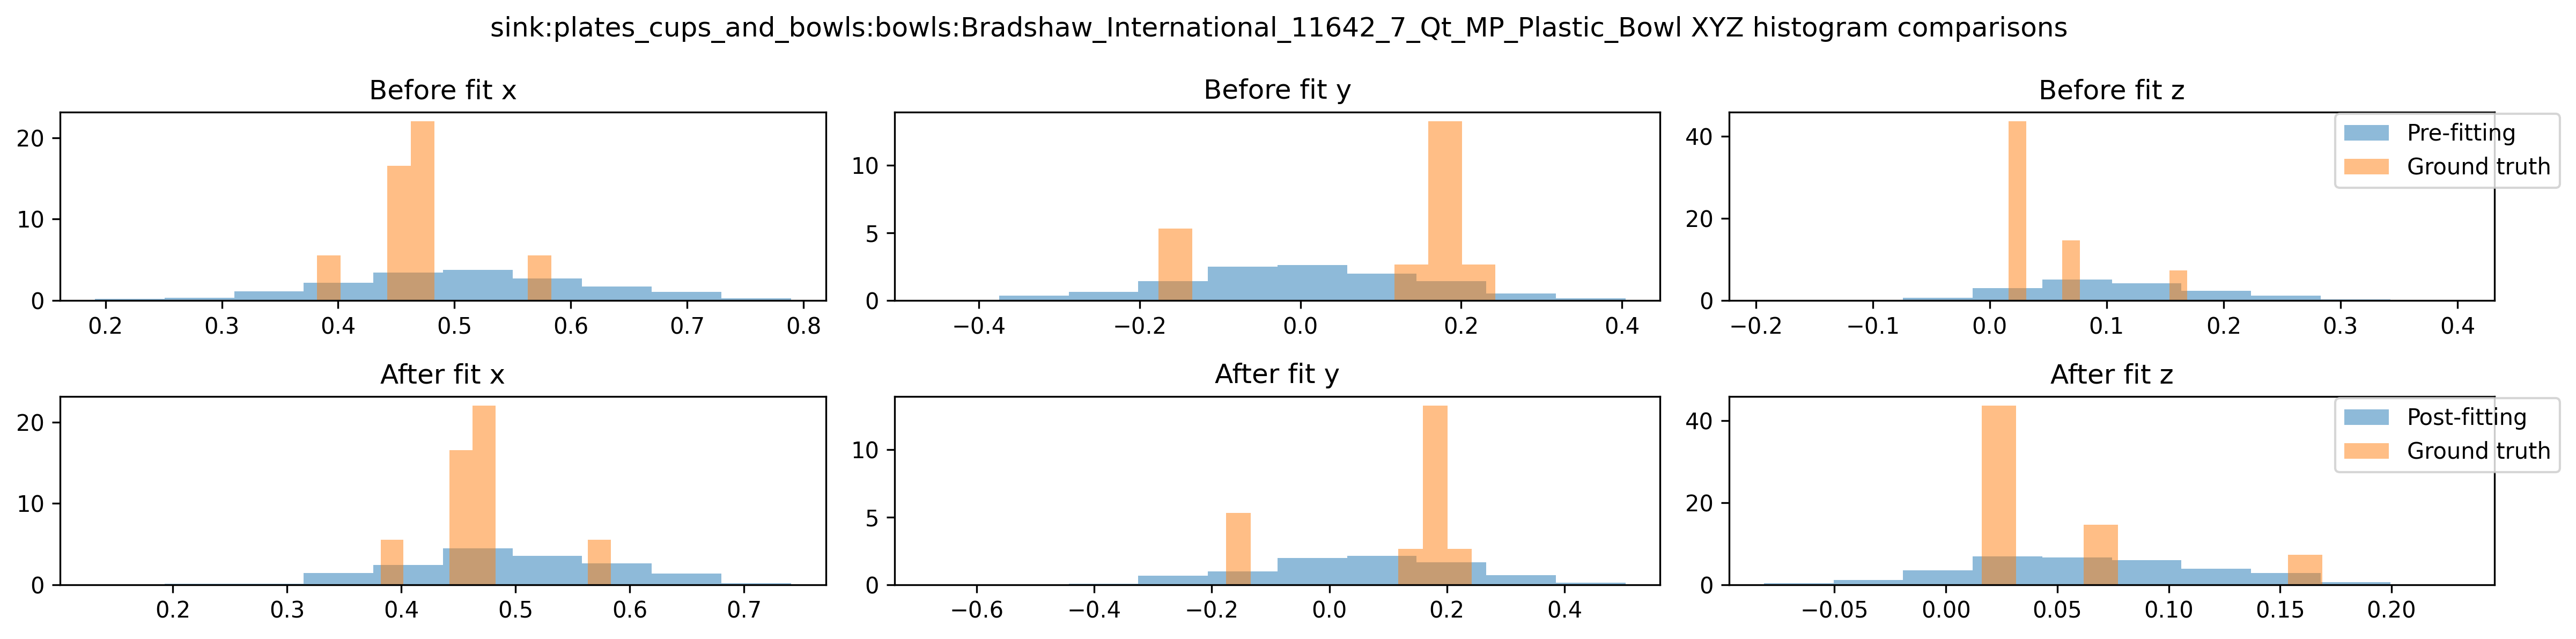

In [17]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [PlateModels[0], CupModels[0], BowlModels[0]]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)

In [ ]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k)

# Test parsing a scene

In [ ]:
# Set up grammar
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
grammar.load_state_dict(torch.load("fit_grammar.torch"))

In [ ]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
results = infer_mle_tree_with_mip(grammar, observed_node_sets[8], N_solutions=1, max_recursion_depth=10, verbose=True)
trees = get_optimized_trees_from_mip_results(results)
vis["parses"].delete()
for k, tree in enumerate(trees[:1]):
    if k == 0:
        draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/contents/%d" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k, alpha=0.25, node_sphere_size=0.01)
    print("Computed score %f, optimization score %f" % (tree.score(verbose=0), results.optim_result.get_suboptimal_objective(k)))

In [ ]:
# Parse all scenes in dataset, and return by best score.
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.

with open("observed_outlier_node_sets.dat", "rb") as f:
    observed_node_sets_outliers = pickle.load(f)
    
parses = get_map_trees_for_observed_node_sets(grammar, observed_node_sets, N_solutions=1, num_workers=10, tqdm=tqdm)
parses = [parse[0] for parse in parses]
scores = torch.stack([parse.score() for parse in parses]).detach().numpy()

parses_outliers = get_map_trees_for_observed_node_sets(grammar, observed_node_sets_outliers, N_solutions=1, num_workers=10, tqdm=tqdm)
parses_outliers = [parse[0] for parse in parses_outliers]
scores_outliers = torch.stack([parse.score() for parse in parses_outliers]).detach().numpy()

In [ ]:
inds_ascending = np.argsort(scores, axis=0)
print("Ranking: ", inds_ascending)
plt.hist(scores, bins=100, label="Training set")
plt.hist(scores_outliers, bins=100, label="Outliers")
plt.xlabel("Log-prob of best parse tree")
plt.ylabel("Occurance in dataset")
plt.legend()
print(parses[-1].score(verbose=True))